In [1]:
# import all necessary packages for SS_LSTM
! pip install -q datasets
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import random
import os
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import collections
import itertools
import re
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from torchtext.vocab import GloVe
from datasets import load_dataset
from sklearn.metrics import accuracy_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64",

/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print device name: get_device_name()
print(torch.cuda.get_device_name(0))


Tesla T4


### Load Dataset from Hugging Face: Paws

In [4]:
# Load the data

def load_data():
    dataset = load_dataset("paws", "labeled_final")
    train_dataset = dataset['train']
    test_dataset = dataset['test']
    val_dataset = dataset['validation']
    return train_dataset, val_dataset, test_dataset


In [5]:
# Load datasets
ltrain_dataset, lval_dataset, ltest_dataset = load_data()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/49401 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/8000 [00:00<?, ? examples/s]

In [ ]:
# Just take 100 samples for now
# ltrain_dataset = ltrain_dataset.select(range(25000))
lval_dataset = lval_dataset.select(range(1000))
# ltest_dataset = ltest_dataset.select(range(8000))

In [6]:
# Check datasets
print(type(ltrain_dataset))

<class 'datasets.arrow_dataset.Dataset'>


### Preprocess Sentences

In [7]:
class Preprocess():
    def __init__(self, sentences):
        self.sentences = sentences

    def tokenize(self):
        self.sentences = [word_tokenize(sentence) for sentence in self.sentences]

    def lowercase(self):
        self.sentences = [[word.lower() for word in sentence] for sentence in self.sentences]

    def remove_stop_words(self):
        stop_words = set(stopwords.words('english'))
        self.sentences = [[word for word in sentence if word not in stop_words] for sentence in self.sentences]

    def stemmer(self):
        stemmer = nltk.stem.PorterStemmer()
        self.sentences = [[stemmer.stem(word) for word in sentence] for sentence in self.sentences]

    def remove_punctuation(self):
        self.sentences = [[word for word in sentence if word.isalpha()] for sentence in self.sentences]

    def remove_numbers(self):
        self.sentences = [[word for word in sentence if not word.isdigit()] for sentence in self.sentences]

    def remove_single_letter(self):
        self.sentences = [[word for word in sentence if len(word) > 1] for sentence in self.sentences]

    def remove_extra_spaces(self):
        self.sentences = [[word for word in sentence if word != ' '] for sentence in self.sentences]

    def remove_less_than_3(self):
        self.sentences = [[word for word in sentence if len(word) > 2] for sentence in self.sentences]

    def run_all(self):
        self.tokenize()
        self.lowercase()
        self.remove_stop_words()
        self.stemmer()
        self.remove_punctuation()
        self.remove_numbers()
        self.remove_single_letter()
        self.remove_extra_spaces()
        self.remove_less_than_3()
        return self.sentences



### Create Embeddings Using Glove

In [8]:
# Load the GloVe embeddings
glove = GloVe(name='6B')
print(glove.vectors.shape)

.vector_cache/glove.6B.zip: 862MB [02:44, 5.26MB/s]                           
100%|█████████▉| 399999/400000 [00:53<00:00, 7537.10it/s]


torch.Size([400000, 300])


### Create Custom Dataset

In [10]:
def sentence_to_indices(sentence, glove, max_len):
    preprocess = Preprocess([sentence])
    # print(sentence)
    sentence = preprocess.run_all()[0]
    length = len(sentence)
    indices = [glove.stoi[word] if word in glove.stoi else glove.stoi['unk'] for word in sentence]
    padded_indices = indices[:max_len] + [0] * (max_len - len(indices))
    flength = length if length < max_len else max_len
    return padded_indices, max_len

def process_dataset(dataset, glove, max_len):
    processed_data = []
    for item in dataset:
        # print(item['id'])
        sentence1_indices, len1 = sentence_to_indices(item['sentence1'], glove, max_len)
        sentence2_indices, len2 = sentence_to_indices(item['sentence2'], glove, max_len)
        label = torch.tensor(item['label'], dtype=torch.long)
        sentence1_tensor = torch.tensor(sentence1_indices, dtype=torch.long)
        sentence2_tensor = torch.tensor(sentence2_indices, dtype=torch.long)
        processed_data.append((sentence1_indices, sentence2_indices, max_len, max_len, label))
    return processed_data

def collate_fn(batch):
    sentence1_batch = torch.tensor([item[0] for item in batch])
    sentence2_batch = torch.tensor([item[1] for item in batch])
    len1_batch = torch.tensor([item[2] for item in batch])
    len2_batch = torch.tensor([item[3] for item in batch])
    labels_batch = torch.tensor([item[4] for item in batch])
    return sentence1_batch, sentence2_batch, len1_batch, len2_batch, labels_batch


In [12]:
# Get the dataset
import nltk
nltk.download('punkt')
nltk.download('stopwords')
train_dataset = process_dataset(ltrain_dataset, glove, 37)
val_dataset = process_dataset(lval_dataset, glove, 37)
test_dataset = process_dataset(ltest_dataset, glove, 37)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [13]:
# Check the dataset
print(train_dataset[1])
print(val_dataset[0])
print(test_dataset[0])

([2809, 195, 195, 513, 389991, 201534, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [195, 513, 389991, 201534, 195, 2809, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 37, 37, tensor(1))
([291910, 249628, 201534, 174620, 29972, 725, 603, 648, 201534, 695, 52, 725, 603, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [291910, 249628, 52, 201534, 174620, 353, 695, 725, 603, 725, 603, 648, 201534, 29972, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 37, 37, tensor(0))
([25335, 9857, 20985, 1224, 201534, 72957, 213766, 94, 751, 201534, 10158, 201534, 45909, 201534, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [25335, 9857, 10158, 2121, 201534, 72957, 213766, 94, 3133, 201534, 20985, 201534, 45909, 201534, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 37, 37, tensor(0))


### Use DataLoader

In [14]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)

In [15]:
# # Check the dataloaders

print(len(train_loader))

for batch in train_loader:
    print(batch)
    break

386
(tensor([[   556, 201534,    943,  ...,      0,      0,      0],
        [ 10602, 353014,  42002,  ...,      0,      0,      0],
        [   512,    253,    373,  ...,      0,      0,      0],
        ...,
        [201534,    311, 201534,  ...,      0,      0,      0],
        [201534, 201534,    922,  ...,      0,      0,      0],
        [201534,    583,    357,  ...,      0,      0,      0]]), tensor([[   556, 201534,    943,  ...,      0,      0,      0],
        [353014,  42002,  10602,  ...,      0,      0,      0],
        [201534,    512,    253,  ...,      0,      0,      0],
        ...,
        [201534, 201534,    311,  ...,      0,      0,      0],
        [201534, 201534, 201534,  ...,      0,      0,      0],
        [201534,    583,    357,  ...,      0,      0,      0]]), tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 37, 3

### Create Model

In [49]:
# Siamise LSTM model
class SS_LSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim):
        super(SS_LSTM, self).__init__()
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(len(glove.vectors), embedding_dim)
        self.embedding.weight.data.copy_(glove.vectors)
        self.embedding.weight.requires_grad = False # Freeze embeddings
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True, num_layers = 3, dropout = 0.5)
        self.fc = nn.Linear(2*hidden_dim*2, 1)
        self.dropout = nn.Dropout(0.2)

    def lstm_forward(self, x, length):
        x = self.embedding(x)
        x = torch.nn.utils.rnn.pack_padded_sequence(x, length, batch_first=True, enforce_sorted=False)
        _, (h, _) = self.lstm(x)
        h = torch.cat((h[-2,:,:], h[-1,:,:]), dim=1)
        return h

    def forward(self, batch):
        # Get the sentence pair and length
        sentence1, sentence2, len1, len2, _ = batch

        # Get the LSTM output
        output1 = self.lstm_forward(sentence1, len1)
        output2 = self.lstm_forward(sentence2, len2)

        # Dropout
        output1 = self.dropout(output1)
        output2 = self.dropout(output2)

        # Concatenate the outputs
        output = torch.cat((output1, output2), dim=1)

        # Get the final output
        output = self.fc(output)
        output = torch.sigmoid(output)

        return output

### Train Model

In [50]:
# Set the hyperparameters
embedding_dim = 300
hidden_dim = 50
lr = 0.01
epochs = 10

# Initialize the model
model = SS_LSTM(embedding_dim, hidden_dim)
model.to(device)

# Define the loss function for binary classification
criterion = nn.BCELoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# print(len(glove.vectors))

In [51]:
# Function for train
def train(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        train_preds = []
        labels = []
        train_loss = 0.0
        val_loss = 0.0
        model.train()
        for batch in tqdm(train_loader):
            batch = [b.to(device) if i != 2 and i != 3 else b for i, b in enumerate(batch)]
            output = model(batch)

            # Get the label
            _, _, _, _, label = batch
            label = label.float()

            similarity = output.squeeze()

            loss = criterion(similarity, label)

            # Backpropagate the loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update the train loss
            train_loss += loss.item()

            # Get the predictions
            preds = [1 if x >= 0.5 else 0 for x in similarity]
            train_preds.extend(preds)
            # Detach the label from GPU
            label = label.detach().cpu().numpy()
            labels.extend(label)

        # Calculate the average loss
        train_loss = train_loss/len(train_loader)
        train_losses.append(train_loss)

        # Calculate the validation loss
        model.eval()
        for batch in tqdm(val_loader):
            batch = [b.to(device) if i != 2 and i != 3 else b for i, b in enumerate(batch)]
            # Get the output from the model
            # output1, output2 = model(batch)
            output = model(batch)

            # Get the label
            _, _, _, _, label = batch
            label = label.float()

            similarity = output.squeeze()
            loss = criterion(similarity, label)

            # Update the validation loss
            val_loss += loss.item()

        # Calculate the average loss
        val_loss = val_loss/len(val_loader)
        val_losses.append(val_loss)

        # Calculate the accuracy
        train_acc = accuracy_score(train_preds, labels)

        # Print the losses and accuracy
        print("Epoch:", epoch+1, "Train Loss:", train_loss, "Val Loss:", val_loss, "Train Accuracy:", train_acc)

    return train_losses, val_losses

In [52]:
# Train the model

train_losses, val_losses = train(model, train_loader, val_loader, criterion, optimizer, epochs)

100%|██████████| 63/63 [00:00<00:00, 81.57it/s]


Epoch: 1 Train Loss: 0.6872853192023045 Val Loss: 0.6855308706798251 Train Accuracy: 0.558166838727961


100%|██████████| 63/63 [00:00<00:00, 127.28it/s]


Epoch: 2 Train Loss: 0.6832934497551597 Val Loss: 0.6840266755649022 Train Accuracy: 0.5657780206878403


100%|██████████| 63/63 [00:00<00:00, 126.30it/s]


Epoch: 3 Train Loss: 0.6776756156293839 Val Loss: 0.6848917092595782 Train Accuracy: 0.5739155077832433


100%|██████████| 63/63 [00:00<00:00, 80.77it/s]


Epoch: 4 Train Loss: 0.6741438364426706 Val Loss: 0.6850846097582862 Train Accuracy: 0.5761016983461873


100%|██████████| 63/63 [00:00<00:00, 123.66it/s]


Epoch: 5 Train Loss: 0.6712962964964654 Val Loss: 0.684741199016571 Train Accuracy: 0.5800692293678266


100%|██████████| 63/63 [00:00<00:00, 125.38it/s]


Epoch: 6 Train Loss: 0.6690509598798703 Val Loss: 0.685080625708141 Train Accuracy: 0.5829841501184186


100%|██████████| 63/63 [00:00<00:00, 66.48it/s]


Epoch: 7 Train Loss: 0.6682446580476712 Val Loss: 0.6857835631521921 Train Accuracy: 0.5833485152122426


100%|██████████| 63/63 [00:00<00:00, 89.69it/s]


Epoch: 8 Train Loss: 0.6665487545759566 Val Loss: 0.6843657531435527 Train Accuracy: 0.5856156757960366


100%|██████████| 63/63 [00:00<00:00, 121.68it/s]


Epoch: 9 Train Loss: 0.6653298025304172 Val Loss: 0.6851912623360044 Train Accuracy: 0.5870124086556953


100%|██████████| 63/63 [00:00<00:00, 122.20it/s]

Epoch: 10 Train Loss: 0.6647875253400655 Val Loss: 0.6844760501195514 Train Accuracy: 0.5878221088641931


In [53]:
# Function to plot the losses: train and validation on the same plot
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend()
    # plt.savefig('/content/drive/MyDrive/ss_bilstm_nn_losses.png')
    plt.show()

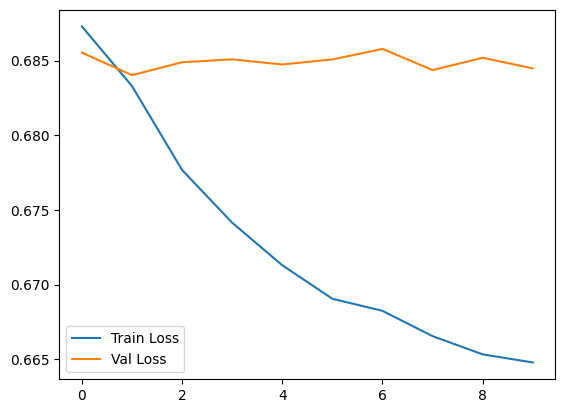

In [54]:
# Call the function to plot the losses
plot_losses(train_losses, val_losses)

In [55]:
# Save the model
torch.save(model.state_dict(), '/content/drive/MyDrive/ss_bilstm_nn_losses.pth')

In [46]:
# load the model
model.load_state_dict(torch.load('/content/drive/MyDrive/ss_bilstm_nn_losses.pth'))

<All keys matched successfully>

### Test the Model

In [56]:
# Function for test
def evaluate(model, test_loader, criterion):
    test_loss = 0.0
    model.eval()
    predictions = []
    labels = []

    for batch in tqdm(test_loader):
        batch = [b.to(device) if i != 2 and i != 3 else b for i, b in enumerate(batch)]
        # Get the output from the model
        # output1, output2 = model(batch)
        output = model(batch)

        # Get the label
        _, _, _, _, label = batch
        label = label.float()

        # Calculate the loss

        # cosine_similarity = F.cosine_similarity(output1, output2)
        # Round cosine similarity to 6 decimal places
        # cosine_similarity = torch.round(cosine_similarity * 1000000) / 1000000

        # Map the similarity to 0 or 1
        # similarity = F.sigmoid(cosine_similarity) # Non-linear mapping
        # similarity = (cosine_similarity + 1)/2 # Linear mapping

        similarity = output.squeeze()

        predicted_label = [1 if x >= 0.5 else 0 for x in similarity]
        predictions.extend(predicted_label)

        loss = criterion(similarity, label)

        label = label.detach().cpu().numpy()
        labels.extend(label.tolist())

        # Update the test loss
        test_loss += loss.item()

    # Calculate the average loss
    test_loss = test_loss/len(test_loader)

    # Print the losses
    print('Test Loss: {:.6f}'.format(test_loss))

    # Calculate the accuracy
    accuracy = accuracy_score(labels, predictions)

    return test_loss, accuracy * 100

In [57]:
# Evaluate the model

test_loss, accuracy = evaluate(model, test_loader, criterion)
print('Accuracy: {:.6f}'.format(accuracy))

100%|██████████| 63/63 [00:00<00:00, 63.48it/s]

Test Loss: 0.685557
Accuracy: 56.337500
